# RAIL's DNF implementation example

Authors: Laura Toribio San Cipriano, Sam Schmidt and Juan De Vicente
last successfully run: Jan 13, 2025

This is a notebook demonstrating some of the features of the LSSTDESC `RAIL` version of the DNF estimator, see **[De Vicente et al. (2016)](https://arxiv.org/abs/1511.07623)** for more details on the algorithm.<br>

DNF (Directional Neighbourhood Fitting) is a nearest-neighbor approach for photometric redshift estimation developed at the CIEMAT (Centro de Investigaciones Energéticas, Medioambientales y Tecnológicas) at Madrid. DNF computes the photo-z hyperplane that best fits the directional neighbourhood of a photometric galaxy in the training sample. 

The current version of the code for `RAIL`consists of a training stage, `DNFInformer` and a estimation stage `DNFEstimator`. `DNFInformer` is a class that preprocesses the protometric data, handles missing or non-detected values, and trains a firts basic k-Nearest Neighbors regressor for redshift prediction. The `DNFEstimator` calculates photometric redshifts based on an enhancement of Nearest Neighbor techniques. The class supports three main metrics for redshift estimation: ENF, ANF or DNF.

- **ENF**: Euclidean neighbourhood. It's a common distance metric used in kNN (k-Nearest Neighbors) for photometric redshift prediction.
- **ANF**: uses normalized inner product for more accurate photo-z predictions. It is particularly **recommended** when working with datasets containing more than four filters.
- **DNF**: combines Euclidean and angular metrics, improving accuracy, especially for larger neighborhoods, and maintaining proportionality in observable content.


### `DNFInformer`

The `DNFInformer` class processes a training dataset and produces a model file containing the computed magnitudes, colors, and their associated errors for the dataset. This model is then utilized in the `DNFEstimator` stage for photometric redshift estimation. Missing photometric detections (non-detections) are handled by replacing them with a configurable placeholder value, or optionally ignoring them during model training.

The configurable parameters for `DNFInformer` include:

- `bands`: List of band names expected in the input dataset.
- `err_bands`: List of magnitude error column names corresponding to the bands.
- `redshift_col`: String indicating the name of the redshift column in the input data.
- `mag_limits`: Dictionary with band names as keys and floats representing the acceptable magnitude range for each band.
- `nondetect_val`: Float or np.nan, the value indicating a non-detection, which will be replaced by the values in mag_limits.
- `replace_nondetect`: Boolean; if True, non-detections are replaced with the specified nondetect_val. If False, non-detections are ignored during the neighbor-finding process.


### `DNFEstimator`

The `DNFEstimator` class uses the model generated by DNFInformer to compute photometric redshifts for new datasets and the PDFs. It identifies the nearest neighbors from the training data using various distance metrics and estimates redshifts based on these neighbors.

The configurable parameters for `DNFEstimator` include:

- `bands`, `err_bands`, `redshift_col`, `nondetect_val`, `mag_limits`: As described for `DNFInformer`.
- `selection_mode`: Integer indicating the method for neighbor selection:
    * `0`: Euclidean Neighbourhood Fitting (ENF).
    * `1`: Angular Neighbourhood Fitting (ANF).
    * `2`: Directional Neighbourhood Fitting (DNF).
- `zmin`, `zmax`, `nzbins`: Float values defining the minimum and maximum redshift range and the number of bins for estimation of the PDFs.
- `pdf_estimation`: Boolean; if True, computes a probability density function (PDF) for the redshift of each object.


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib inline 

In [2]:
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## Training the informer

You can configure DNF by setting options in a dictionary when initializing an instance of our `DNFInformer` stage. Any parameters not explicitly defined will use their default values.

In [4]:
dnf_dict = dict(zmin=0.0, zmax=3.0, nzbins=301, hdf5_groupname='photometry')

We will begin by training the algorithm, to to this we instantiate a rail object with a call to the base class.<br>

In [5]:
from rail.estimation.algos.dnf import DNFInformer, DNFEstimator
pz_train = DNFInformer.make_stage(name='inform_DNF', model='demo_DNF_model.pkl', **dnf_dict)

Now, let's load our training data, which is stored in hdf5 format.  We'll load it into the Data Store so that the ceci stages are able to access it.

In [6]:
from rail.utils.path_utils import RAILDIR
trainFile = os.path.join(RAILDIR, 'rail/examples_data/testdata/test_dc2_training_9816.hdf5')
testFile = os.path.join(RAILDIR, 'rail/examples_data/testdata/test_dc2_validation_9816.hdf5')
training_data = DS.read_file("training_data", TableHandle, trainFile)
test_data = DS.read_file("test_data", TableHandle, testFile)

The inform stage of DNF transforms magnitudes into colors, corrects undetected values in the training data, and saves them as a model dictionary. This dictionary is then stored in a pickle file specified by the model keyword above, in this case, ‘demo_dnf_model.pkl’.

In [7]:
%%time
pz_train.inform(training_data)

Inserting handle into data store.  model_inform_DNF: inprogress_demo_DNF_model.pkl, inform_DNF
CPU times: user 8.12 ms, sys: 1.07 ms, total: 9.19 ms
Wall time: 9.12 ms


## Run DNF

Now, we can configure the main photo-z stage and run our algorithm on the data to generate basic photo-z estimates. Keep in mind that we are loading the trained model obtained from the inform stage using the statement`model=pz_train.get_handle('model')`. We will set `nondetect_replace` to `True` to replace non-detection magnitudes with their 1-sigma limits and utilize all colors.

DNF provides three methods for selecting the distance metric: Euclidean ("ENF," set with `selection_mode` of `0`), Angular ("ANF," set with `selection_mode = 1`, which is the default for this stage), and Directional ("DNF," set with `selection_mode = 2`).

For our first example, we will set `selection_mode` to `1`, using the angular distance:

In [8]:
%%time
pz = DNFEstimator.make_stage(name='DNF_estimate', hdf5_groupname='photometry',
                        model=pz_train.get_handle('model'),
                        selection_mode=1,
                        nondetect_replace=True)
results = pz.estimate(test_data)

using metric ANF
Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000


/home/laura/Documentos/LSST/rail_dnf/src/rail/estimation/algos/dnf.py:400: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(1.0 - NIP**2)
/home/laura/Documentos/LSST/rail_dnf/src/rail/estimation/algos/dnf.py:445: RuntimeWarning: divide by zero encountered in divide
  inverse_distances = 1.0 / distances
/home/laura/Documentos/LSST/rail_dnf/src/rail/estimation/algos/dnf.py:453: RuntimeWarning: invalid value encountered in divide
  wmatrix = inverse_distances / row_sum
/home/laura/anaconda3/envs/[env]/lib/python3.12/site-packages/qp/interp_pdf.py:82: RuntimeWarning: invalid value encountered in divide
  self._yvals = (self._yvals.T / self._ycumul[:,-1]).T
/home/laura/anaconda3/envs/[env]/lib/python3.12/site-packages/qp/interp_pdf.py:83: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:,-1]).T


Inserting handle into data store.  output_DNF_estimate: inprogress_output_DNF_estimate.hdf5, DNF_estimate
Process 0 running estimator on chunk 10000 - 20000
Process 0 estimating PZ PDF for rows 10,000 - 20,000


/home/laura/Documentos/LSST/rail_dnf/src/rail/estimation/algos/dnf.py:400: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt(1.0 - NIP**2)
/home/laura/Documentos/LSST/rail_dnf/src/rail/estimation/algos/dnf.py:445: RuntimeWarning: divide by zero encountered in divide
  inverse_distances = 1.0 / distances
/home/laura/Documentos/LSST/rail_dnf/src/rail/estimation/algos/dnf.py:453: RuntimeWarning: invalid value encountered in divide
  wmatrix = inverse_distances / row_sum
/home/laura/anaconda3/envs/[env]/lib/python3.12/site-packages/qp/interp_pdf.py:82: RuntimeWarning: invalid value encountered in divide
  self._yvals = (self._yvals.T / self._ycumul[:,-1]).T
/home/laura/anaconda3/envs/[env]/lib/python3.12/site-packages/qp/interp_pdf.py:83: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:,-1]).T


Process 0 running estimator on chunk 20000 - 20449
Process 0 estimating PZ PDF for rows 20,000 - 20,449
CPU times: user 10.9 s, sys: 429 ms, total: 11.3 s
Wall time: 11.3 s


DNF calculates its own point estimate, `DNF_Z`, which is stored in the qp Ensemble `ancil` data. Also, DNF calculates other photo-zs called `DNF_ZN`.

- `DNF_Z` represents the photometric redshift for each galaxy computed as the weighted average or hyperplane fit (depending on the option selected) for a set of neighbors determined by a specific metric (ENF, ANF, DNF) where the outliers are removed

- `DNF_ZN` represents the photometric redshift using only the closest neighbor. It is mainly used for computing the redshift distributions.
  
Let's plot that versus the true redshift.  We can also compute the PDF mode for each object and plot that as well:


In [9]:
zdnf = results().ancil['DNF_Z'].flatten()

In [10]:
zn_dnf = results().ancil['DNF_ZN'].flatten()

In [11]:
zgrid = np.linspace(0,3,301)
zmode = results().mode(zgrid).flatten()

In [12]:
zmode

array([0.19, 0.07, 0.07, ..., 0.13, 2.47, 2.73])

Let's plot the redshift mode against the true redshifts to see how they look:

(0.0, 3.0)

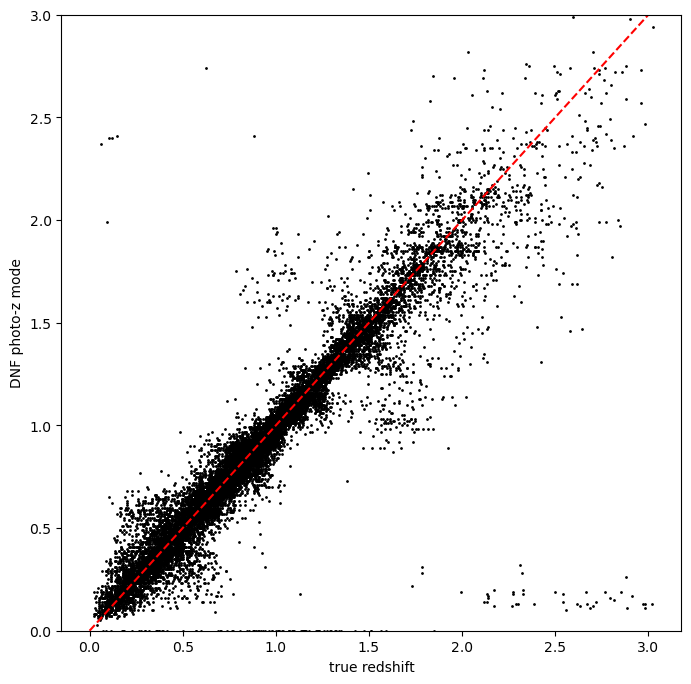

In [13]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'],zmode,s=1,c='k',label='DNF mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("DNF photo-z mode")
plt.ylim(0,3)

(0.0, 3.0)

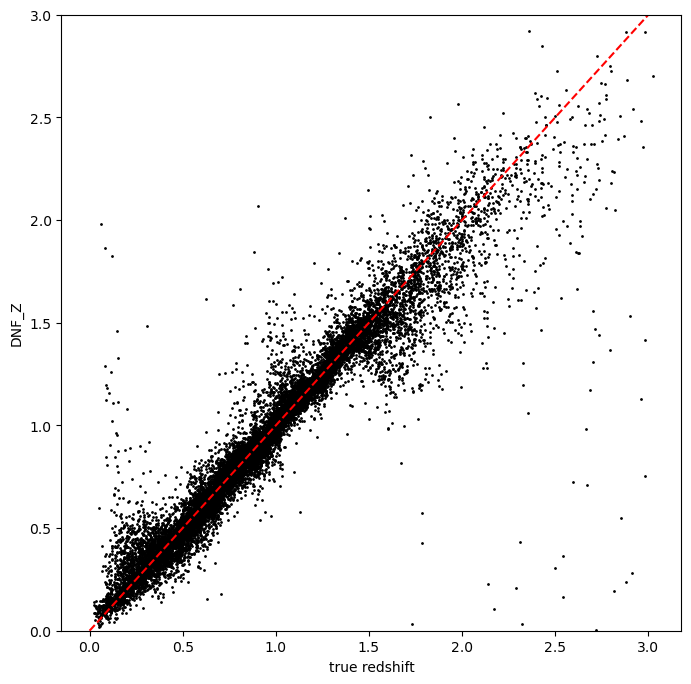

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'], zdnf, s=1, c='k')
plt.plot([0,3],[0,3], 'r--');
plt.xlabel("true redshift")
plt.ylabel("DNF_Z")
plt.ylim(0,3)

(0.0, 3.0)

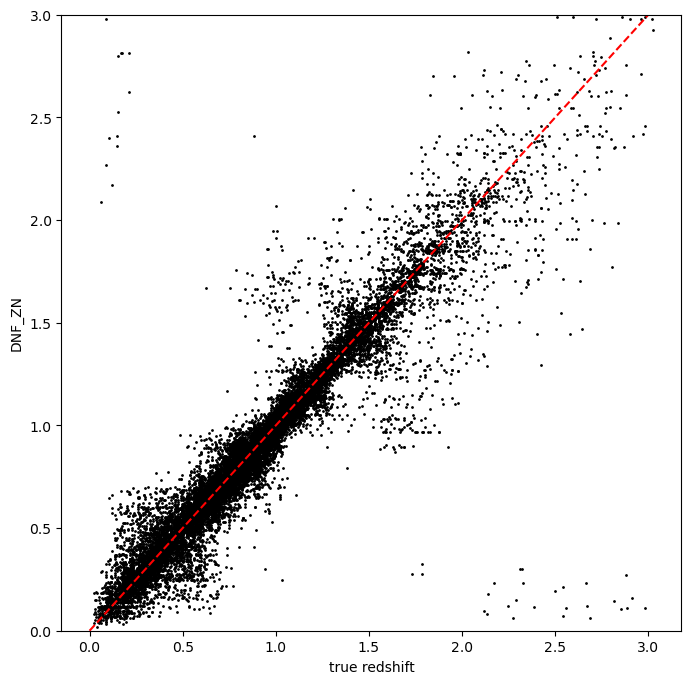

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'], zn_dnf, s=1, c='k')
plt.plot([0,3],[0,3], 'r--');
plt.xlabel("true redshift")
plt.ylabel("DNF_ZN")
plt.ylim(0,3)

## plotting PDFs

In addition to point estimates, we can also plot a few of the full PDFs produced by DNF using the `plot_native` method of the qp Ensemble that we've created as `results`.  We can specify which PDF to plot with the `key` argument to `plot_native`, let's plot four, the 5th, 1380th, 14481st, and 18871st:

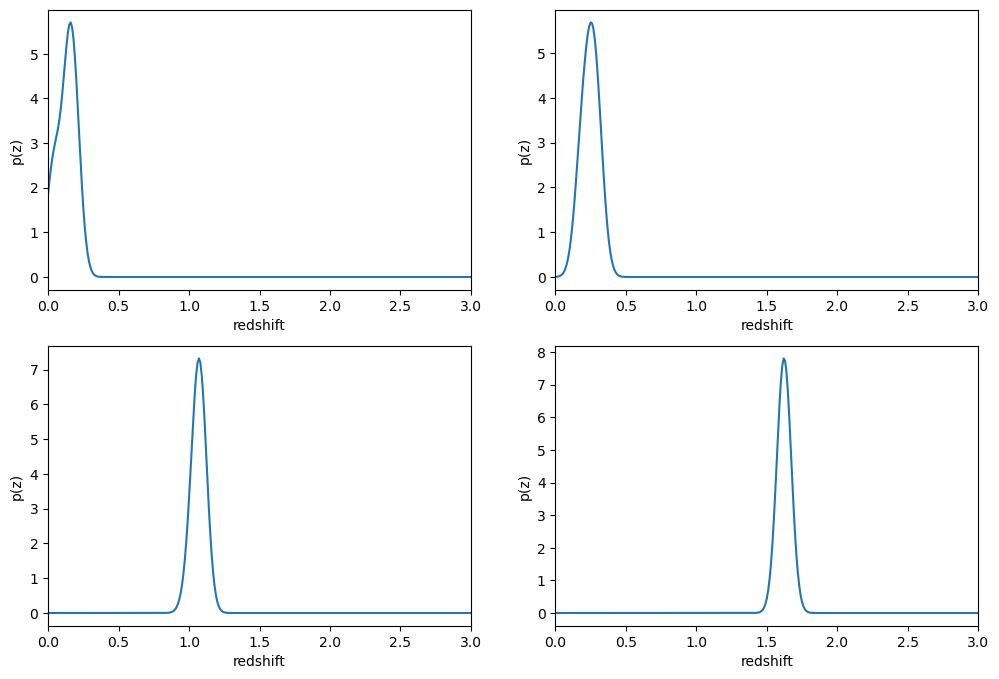

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
whichgals = [4, 1379, 14480, 18870]
for ax, which in zip(axs.flat, whichgals):
    ax.set_xlim(0,3)
    results().plot_native(key=which, axes=ax)
    ax.set_xlabel("redshift")
    ax.set_ylabel("p(z)")

# Other distance metrics

Besides DNF there are options for ENF and ANF.

Let's run our estimator using `selection_mode=0` for the Euclidean distance, and compare both the mode results and PDF results:

In [17]:
%%time
pz2 = DNFEstimator.make_stage(name='DNF_estimate2', hdf5_groupname='photometry',
                        model=pz_train.get_handle('model'),
                        selection_mode=0,
                        nondetect_replace=True)
results2 = pz2.estimate(test_data)

using metric ENF
Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_DNF_estimate2: inprogress_output_DNF_estimate2.hdf5, DNF_estimate2
Process 0 running estimator on chunk 10000 - 20000
Process 0 estimating PZ PDF for rows 10,000 - 20,000
Process 0 running estimator on chunk 20000 - 20449
Process 0 estimating PZ PDF for rows 20,000 - 20,449
CPU times: user 8.34 s, sys: 389 ms, total: 8.73 s
Wall time: 8.77 s


In [19]:
zdnf2 = results2().ancil['DNF_Z'].flatten()

In [20]:
zgrid = np.linspace(0,3,301)
zmode2 = results2().mode(zgrid).flatten()

(0.0, 3.0)

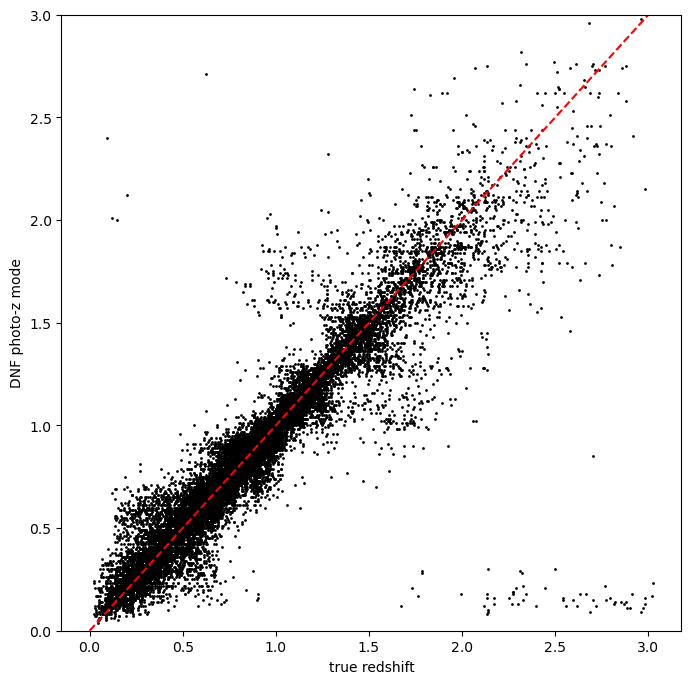

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'],zmode2,s=1,c='k',label='DNF mode')
plt.plot([0,3],[0,3],'r--');
plt.xlabel("true redshift")
plt.ylabel("DNF photo-z mode")
plt.ylim(0,3)

(0.0, 3.0)

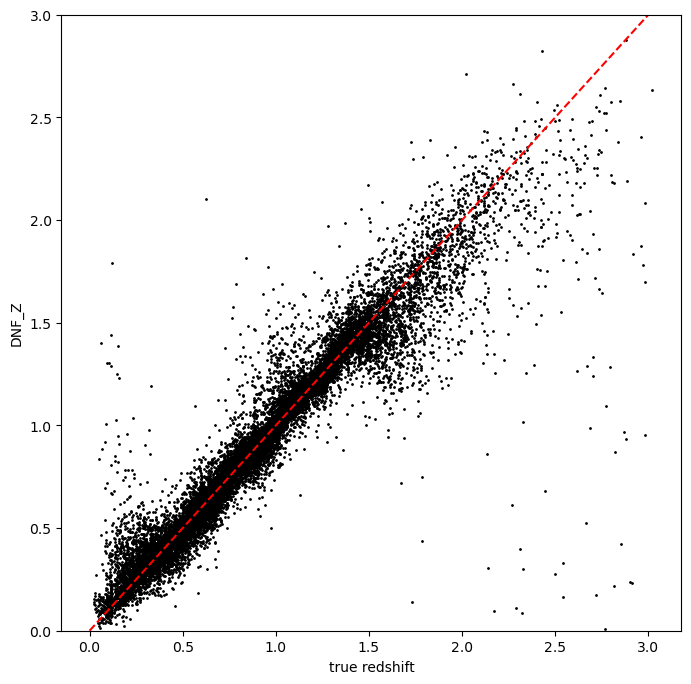

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'], zdnf2, s=1, c='k')
plt.plot([0,3],[0,3], 'r--');
plt.xlabel("true redshift")
plt.ylabel("DNF_Z")
plt.ylim(0,3)

Let's directly compare the "angular" and "Euclidean" distance estimates on the same axes:

(0.0, 3.0)

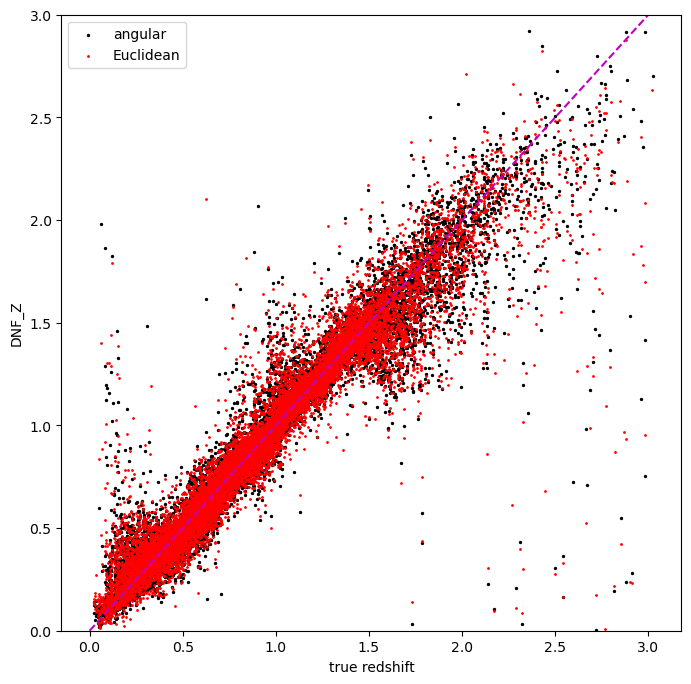

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'], zdnf, s=2, c='k', label="angular")
plt.scatter(test_data()['photometry']['redshift'], zdnf2, s=1, c='r', label="Euclidean")
plt.legend(loc='upper left', fontsize=10)
plt.plot([0,3],[0,3], 'm--');
plt.xlabel("true redshift")
plt.ylabel("DNF_Z")
plt.ylim(0,3)

(0.0, 3.0)

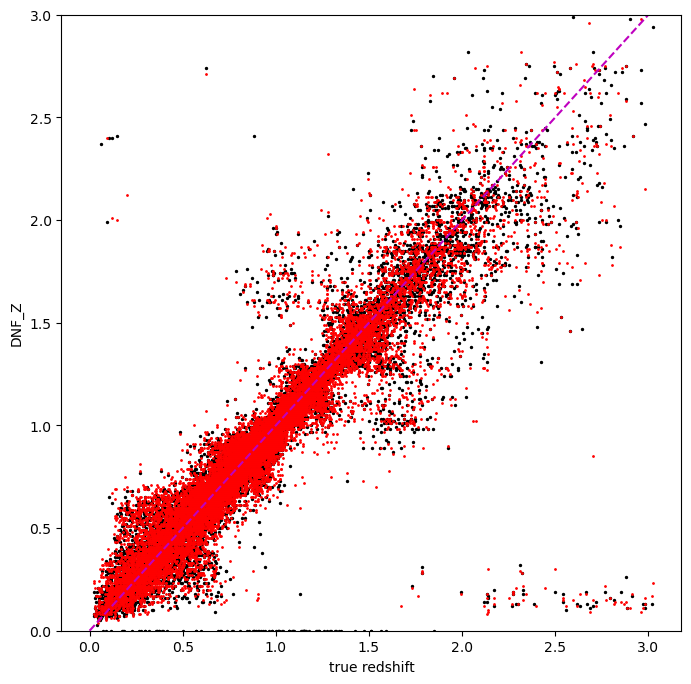

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(test_data()['photometry']['redshift'], zmode, s=2, c='k')
plt.scatter(test_data()['photometry']['redshift'], zmode2, s=1, c='r')
plt.plot([0,3],[0,3], 'm--');
plt.xlabel("true redshift")
plt.ylabel("DNF_Z")
plt.ylim(0,3)

Finally, let's directly compare the same PDFs that we plotted above

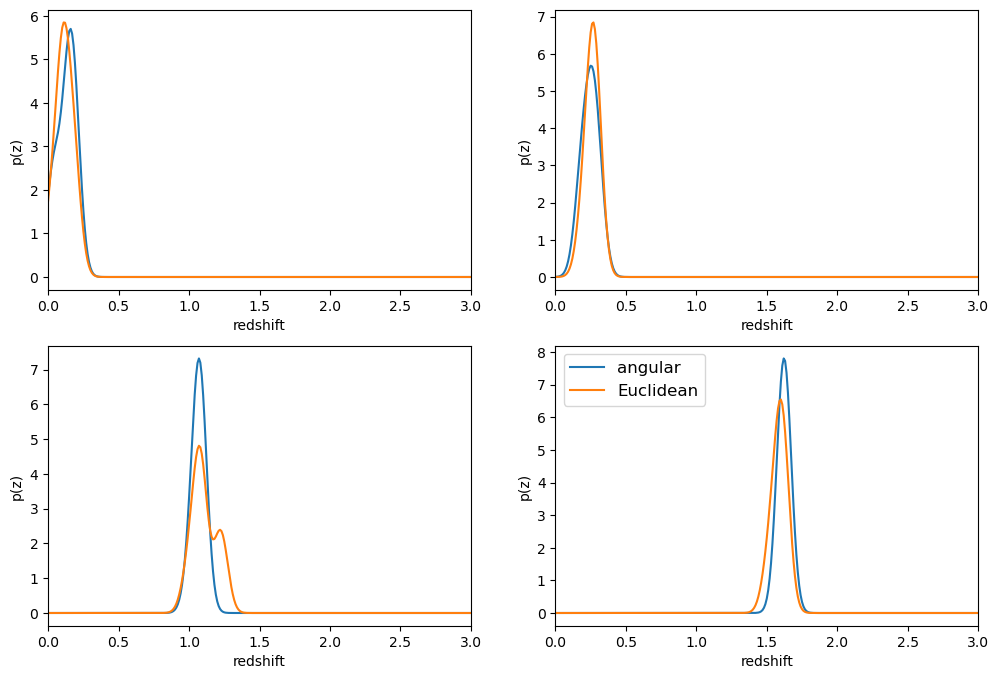

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
whichgals = [4, 1379, 14480, 18870]
for ax, which in zip(axs.flat, whichgals):
    ax.set_xlim(0,3)
    results().plot_native(key=which, axes=ax, label="angular")
    results2().plot_native(key=which, axes=ax, label="Euclidean")
    ax.set_xlabel("redshift")
    ax.set_ylabel("p(z)")
ax.legend(loc='upper left', fontsize=12)